<a href="https://colab.research.google.com/github/bkrosenz/graph_nets/blob/master/demos_tf2/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [0]:
import sys
assert sys.version_info >= (3, 6), "Sonnet 2 requires Python >=3.6"

In [2]:
#!pip install dm-sonnet tqdm

#@title ### Install the Graph Nets library on this Colaboratory runtime  { form-width: "60%", run: "auto"}
#@markdown <br>1. Connect to a local or hosted Colaboratory runtime by clicking the **Connect** button at the top-right.<br>2. Choose "Yes" below to install the Graph Nets library on the runtime machine with the correct dependencies. Note, this works both with local and hosted Colaboratory runtimes.

install_graph_nets_library = "Yes"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet" "tensorflow-probability"
else:
  print("Skipping installation of Graph Nets library")

# print("Installing dependencies for Colab environment")
# !pip install -q -Uq grpcio==1.29.0


# print('Installing TensorFlow Transform')
# !pip install -q -Uq tensorflow-transform==0.22.0
# import tensorflow_transform as tft

Installing Graph Nets library and dependencies:
Output message from command:



In [0]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()


import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import sonnet as snt
#import tensorflow as tf
from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
import networkx as nx
import numpy as np



In [4]:
print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))

TensorFlow version: 2.2.0
    Sonnet version: 2.0.0


Finally lets take a quick look at the GPUs we have available:

In [5]:
!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'

physical_gpus = tf.config.experimental.list_physical_devices("GPU")


grep: /proc/driver/nvidia/gpus/*/information: No such file or directory


# Common graph for all inputs
Prepare a fixed graph from the sparse precision matrix using a graphical lasso

In [0]:
dataset = (
      tfds.load("cifar10", split="train", as_supervised=True)
       .batch(10000)
)
for x,y in dataset.take(1):
  x= tf.divide(
      tf.cast(
          tf.reshape(tf.image.rgb_to_grayscale(x),
                     (10000,1024)),
              tf.float32),
          255.
          )

cfull=tfp.stats.covariance(x,sample_axis=0)
p = tf.math.log(tf.math.abs(tf.linalg.inv(cfull)))

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
t_old=0
for t in np.arange(5,8,.1):
  pfull=p.numpy()
  pfull[pfull<t]=0
  g=nx.Graph(zip(*np.nonzero(pfull))).to_undirected()
  gc=next(nx.connected_components(g))
  print(t,len(gc))
  if len(gc)<1024:
    break
  t_old=t
  

5.0 1024
5.1 1024
5.199999999999999 1024
5.299999999999999 1024
5.399999999999999 1024
5.499999999999998 1024
5.599999999999998 1024
5.6999999999999975 1024
5.799999999999997 1024
5.899999999999997 1024
5.9999999999999964 1024
6.099999999999996 1024
6.199999999999996 1024
6.299999999999995 1024
6.399999999999995 1024
6.499999999999995 1024
6.599999999999994 1024
6.699999999999994 1022


6.599999999999994


1024

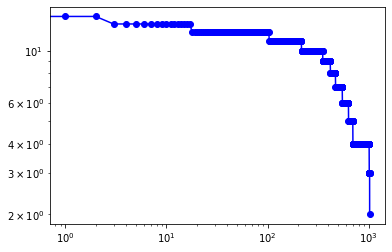

In [8]:
print(t_old)
pfull=p.numpy()
cov=cfull.numpy()
cov[pfull<t_old]=0

pfull[pfull<t_old]=0



senders,receivers = np.nonzero(pfull)
senders=senders.astype(np.uint16)
receivers=receivers.astype(np.uint16)
# senders=tf.constant(senders,dtype=tf.uint16)
# receivers=tf.constant(receivers,dtype=tf.uint16)
# edges = tf.constant(cov[senders,receivers],dtype=tf.float16)
edges = cov[senders,receivers].astype(np.float16)

np.save('cov.npz',cov)
np.save('pfull.npz',pfull)

np.fill_diagonal(pfull,0)
g=nx.Graph(zip(*np.nonzero(pfull))).to_undirected()


degree_sequence=sorted((v for k,v in nx.degree(g)),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)
plt.loglog(degree_sequence,'b-',marker='o')
gc=next(nx.connected_components(g))
len(gc)

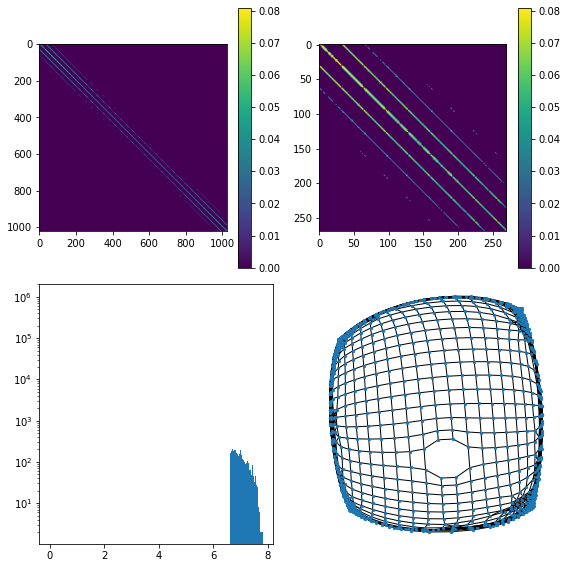

In [9]:

plt.figure(figsize=(8,8))
plt.subplot(221)
ax=plt.imshow(cov)
plt.colorbar(ax)

plt.subplot(222)
ax=plt.imshow(cov[:270,:270])
plt.colorbar(ax)

plt.subplot(223)
plt.hist(pfull.ravel(),bins=500,log=True)

plt.subplot(224)
nx.draw_spectral(g,node_size=5)

plt.tight_layout()
plt.savefig('res.png')

del p,pfull,cov,cfull,x,y,dataset


In [10]:
2**15
gt=utils_tf.data_dicts_to_graphs_tuple([{
      'n_node':1024,
    "senders": senders,
    "receivers": receivers,
    'globals':[9],
    'nodes':range(1024)}])
print(utils_np.graphs_tuple_to_networkxs(gt))

# senders=tf.cast(senders,dtype=tf.int16)
# receivers=tf.cast(receivers,dtype=tf.int16)
# edges=tf.cast(edges,tf.float16)

# Dataset

CIFAR-10 contains 32x32 pixel color images in 10 different classes (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks).

50,000 training and 10,000 testing images

top-1 accuracy of Sonnet2's VGG network = 0.84559995


In [0]:
batch_size = 10

def process_batch(images, labels):
  images = tf.cast(images, dtype=tf.float16)
  images = ((images / 255.) - .5) * 2.
  images = tf.reshape(images,(-1,3))
  graph = utils_tf.data_dicts_to_graphs_tuple([{
    'n_node':1024,
    "senders": senders,
    "receivers": receivers,
    'edges':edges,
    'globals':tf.zeros((10,),dtype=tf.float16),
    'nodes':images}])
  # graph = utils_tf.set_zero_global_features(graph,10)
  # graph.receivers=tf.cast(graph.receivers, tf.uint16)
  return graph, labels

def cifar10(split):
  dataset = (
      tfds.load("cifar10", split=split, as_supervised=True)
       .map(process_batch)
       .batch(batch_size)
       .prefetch(tf.data.experimental.AUTOTUNE)
       .cache()
  )
  return dataset

cifar10_train = cifar10("train").shuffle(10)
cifar10_test = cifar10("test")

# Build GNN model


In [0]:
NUM_LAYERS = 4 # Hard-code number of layers in the edge/node/global models.
LATENT_SIZE = 16  # Hard-code latent layer sizes for demos.

def make_mlp_model():
  """Instantiates a new MLP, followed by LayerNorm.
  The parameters of each new MLP are not shared with others generated by
  this function.
  Returns:
    A Sonnet module which contains the MLP and LayerNorm.
  """
  return snt.Sequential([
      snt.nets.MLP([LATENT_SIZE] * NUM_LAYERS, activate_final=True),
      snt.LayerNorm(axis=-1, create_offset=True, create_scale=True)
  ])


class MLPGraphIndependent(snt.Module):
  """GraphIndependent with MLP edge, node, and global models."""

  def __init__(self, name="MLPGraphIndependent"):
    super(MLPGraphIndependent, self).__init__(name=name)
    self._network = modules.GraphIndependent(
        edge_model_fn=make_mlp_model,
        node_model_fn=make_mlp_model,
        global_model_fn=make_mlp_model)

  def __call__(self, inputs):
    return self._network(inputs)


class MLPGraphNetwork(snt.Module):
  """GraphNetwork with MLP edge, node, and global models."""

  def __init__(self, name="MLPGraphNetwork"):
    super(MLPGraphNetwork, self).__init__(name=name)
    self._network = modules.GraphNetwork(make_mlp_model, make_mlp_model,
                                         make_mlp_model)

  def __call__(self, inputs):
    return self._network(inputs)


class EncodeProcessDecode(snt.Module):
  """Full encode-process-decode model.
  The model we explore includes three components:
  - An "Encoder" graph net, which independently encodes the edge, node, and
    global attributes (does not compute relations etc.).
  - A "Core" graph net, which performs N rounds of processing (message-passing)
    steps. The input to the Core is the concatenation of the Encoder's output
    and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
    the processing step).
  - A "Decoder" graph net, which independently decodes the edge, node, and
    global attributes (does not compute relations etc.), on each message-passing
    step.
                      Hidden(t)   Hidden(t+1)
                         |            ^
            *---------*  |  *------*  |  *---------*
            |         |  |  |      |  |  |         |
  Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
            |         |---->|      |     |         |
            *---------*     *------*     *---------*
  """

  def __init__(self,
               global_output_size=10,
               name="EncodeProcessDecode"):
    super(EncodeProcessDecode, self).__init__(name=name)
    self._encoder = MLPGraphIndependent()
    self._core = MLPGraphNetwork()
    self._decoder = MLPGraphIndependent()
    # Transforms the outputs into the appropriate shapes.
    global_fn = lambda: snt.Linear(global_output_size, name="global_output")
    self._output_transform = modules.GraphIndependent(global_model_fn=global_fn)

  def __call__(self, input_op, num_processing_steps):
    latent = self._encoder(input_op)
    latent0 = latent
    output_ops = []
    for _ in range(num_processing_steps):
      core_input = utils_tf.concat([latent0, latent], axis=1)
      latent = self._core(core_input)
      decoded_op = self._decoder(latent)
      output_ops.append(self._output_transform(decoded_op))
    return output_ops

In [0]:
#@title Loss and Accuracy
def create_loss(labels,graph):
  return tf.nn.sparse_softmax_cross_entropy_with_logits(logits=graph.globals,
                                                          labels=labels)
  
def compute_accuracy():
  pass

# Train

In [0]:
num_processing_steps_tr = 6

# Data / training parameters.

# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)

model = EncodeProcessDecode()
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []


# Training.
#@tf.function
def update_step(inputs_tr, targets_tr):
  print(inputs_tr.senders,inputs_tr.receivers)
  with tf.GradientTape() as tape:
    outputs_tr = model(inputs_tr, num_processing_steps_tr)
    # Loss.
    loss_tr = create_loss(targets_tr, outputs_tr)
    loss_tr = tf.math.reduce_sum(loss_tr) / num_processing_steps_tr

  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return loss_tr

In [39]:
#@title Compiling update_step with `tf_function`  { form-width: "30%" }
"""To recover the speed of TensorFlow 1, we need to use `tf.function` to
compile the update_step into a graph. However, using `tf.function` naively
may futher reduce performance as the number of nodes/edges in the batch can
change across batches, tensorflow will repeatedly trace the function multiple
times for each unique shape of the input tensors.
Instead, we obtain an explicit signature for each input argument to
`update_step` using `utils_tf.specs_from_graphs_tuple` that sets `None` sizes
for variable length axes in graph fields, preventing `tf.function` from having
to trace the function repeatedly."""

# Get some example data that resembles the tensors that will be fed
# into update_step():

for x,y in cifar10_train.unbatch().batch(1).take(1):
  example_input_data, example_target_data = x,y

# example_input_data = utils_tf.set_zero_edge_features(example_input_data, 0)
print(example_input_data,'\ny',example_target_data) 
# Get the input signature for that function by obtaining the specs
input_signature = [
  utils_tf.specs_from_graphs_tuple(example_input_data),
  tf.TensorSpec((None,))
]
print(example_input_data)
print(input_signature)
# Compile the update function using the input signature for speedy code.
compiled_update_step = tf.function(update_step, input_signature=input_signature)

GraphsTuple(nodes=<tf.Tensor: shape=(1, 1024, 3), dtype=float16, numpy=
array([[[-0.2393 , -0.09814, -0.5215 ],
        [-0.1924 , -0.03516, -0.545  ],
        [-0.3335 , -0.1924 , -0.5684 ],
        ...,
        [-0.4194 , -0.3335 , -0.5684 ],
        [-0.3179 , -0.2002 , -0.5293 ],
        [-0.349  , -0.255  , -0.545  ]]], dtype=float16)>, edges=<tf.Tensor: shape=(1, 8565), dtype=float16, numpy=
array([[0.08093, 0.0778 , 0.07776, ..., 0.0552 , 0.0557 , 0.0581 ]],
      dtype=float16)>, receivers=<tf.Tensor: shape=(1, 8565), dtype=int32, numpy=array([[   0,    1,   32, ...,  991, 1022, 1023]], dtype=int32)>, senders=<tf.Tensor: shape=(1, 8565), dtype=int32, numpy=array([[   0,    0,    0, ..., 1023, 1023, 1023]], dtype=int32)>, globals=<tf.Tensor: shape=(1, 1, 10), dtype=float16, numpy=array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float16)>, n_node=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1024]], dtype=int32)>, n_edge=<tf.Tensor: shape=(1, 1), dtype=int32, nump

In [40]:

for x,y in cifar10_train.take(1):
  example_input_data, example_target_data = x,y

# example_input_data = utils_tf.set_zero_edge_features(example_input_data, 0)
print(example_input_data,'\ny',example_target_data) 

GraphsTuple(nodes=<tf.Tensor: shape=(10, 1024, 3), dtype=float16, numpy=
array([[[-0.357   , -0.145   , -0.545   ],
        [-0.3647  , -0.1528  , -0.545   ],
        [-0.2783  , -0.0747  , -0.4512  ],
        ...,
        [ 0.5605  ,  0.4668  ,  0.545   ],
        [ 0.5605  ,  0.4668  ,  0.545   ],
        [ 0.5527  ,  0.459   ,  0.545   ]],

       [[-0.255   , -0.3018  , -0.435   ],
        [-0.1841  , -0.294   , -0.4194  ],
        [-0.0747  , -0.3018  , -0.4116  ],
        ...,
        [-0.3096  , -0.09814 , -0.4272  ],
        [-0.2627  , -0.05078 , -0.3882  ],
        [-0.3096  , -0.10596 , -0.4194  ]],

       [[ 0.3965  ,  0.4824  ,  0.0664  ],
        [ 0.3887  ,  0.506   ,  0.003906],
        [ 0.498   ,  0.615   ,  0.169   ],
        ...,
        [ 0.0664  ,  0.2705  , -0.0825  ],
        [-0.01172 ,  0.2002  , -0.1763  ],
        [ 0.003906,  0.2314  , -0.1606  ]],

       ...,

       [[-0.02734 , -0.04297 , -0.145   ],
        [-0.1924  , -0.208   , -0.3018  ],
        [

In [43]:
#@title Run training steps  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# Instantiate the model.

def train_epoch(dataset):
  """Performs one epoch of training, returning the mean cross-entropy loss."""
  total_loss = 0.0
  num_batches = 0

  # Loop overb the entire training set.
  for images, labels in dataset:
    # print(images, labels)
    # loss_tr = compiled_update_step(images, labels)
    loss_tr = update_step(images, labels)
    total_loss += loss_tr.sum()
    num_batches += 1
  print(num_batches)

  return total_loss / num_batches

for epoch in range(10):
  print("Training epoch", epoch, "...", end=" ")
  print("loss :=", train_epoch(cifar10_train))
  

Training epoch 0 ... tf.Tensor(
[[   0    0    0 ... 1023 1023 1023]
 [   0    0    0 ... 1023 1023 1023]
 [   0    0    0 ... 1023 1023 1023]
 ...
 [   0    0    0 ... 1023 1023 1023]
 [   0    0    0 ... 1023 1023 1023]
 [   0    0    0 ... 1023 1023 1023]], shape=(10, 8565), dtype=int32) tf.Tensor(
[[   0    1   32 ...  991 1022 1023]
 [   0    1   32 ...  991 1022 1023]
 [   0    1   32 ...  991 1022 1023]
 ...
 [   0    1   32 ...  991 1022 1023]
 [   0    1   32 ...  991 1022 1023]
 [   0    1   32 ...  991 1022 1023]], shape=(10, 8565), dtype=int32)


InvalidArgumentError: ignored

NameError: ignored

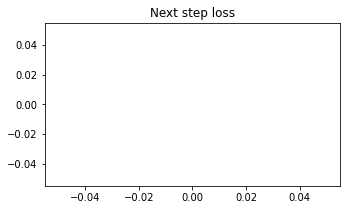

In [42]:
#@title Visualize loss curves  { form-width: "30%" }

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  return np.split(rollout_array[..., :2], batch_size, axis=1)


fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")
# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 5-mass string")
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")

# Visualize trajectories.
true_rollouts_4 = get_node_trajectories(test_values["true_rollout_4"],
                                        batch_size_ge)
predicted_rollouts_4 = get_node_trajectories(test_values["predicted_rollout_4"],
                                             batch_size_ge)
true_rollouts_9 = get_node_trajectories(test_values["true_rollout_9"],
                                        batch_size_ge)
predicted_rollouts_9 = get_node_trajectories(test_values["predicted_rollout_9"],
                                             batch_size_ge)

true_rollouts = true_rollouts_4
predicted_rollouts = predicted_rollouts_4
true_rollouts = true_rollouts_9
predicted_rollouts = predicted_rollouts_9

num_graphs = len(true_rollouts)
num_time_steps = true_rollouts[0].shape[0]

# Plot state sequences.
max_graphs_to_plot = 1
num_graphs_to_plot = min(num_graphs, max_graphs_to_plot)
num_steps_to_plot = 24
max_time_step = num_time_steps - 1
step_indices = np.floor(np.linspace(0, max_time_step,
                                    num_steps_to_plot)).astype(int).tolist()
w = 6
h = int(np.ceil(num_steps_to_plot / w))
fig = plt.figure(101, figsize=(18, 8))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  xys = np.hstack([predicted_rollout, true_rollout]).reshape([-1, 2])
  xs = xys[:, 0]
  ys = xys[:, 1]
  b = 0.05
  xmin = xs.min() - b * xs.ptp()
  xmax = xs.max() + b * xs.ptp()
  ymin = ys.min() - b * ys.ptp()
  ymax = ys.max() + b * ys.ptp()
  if i >= num_graphs_to_plot:
    break
  for j, step_index in enumerate(step_indices):
    iax = i * w + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(
        true_rollout[step_index, :, 0],
        true_rollout[step_index, :, 1],
        "k",
        label="True")
    ax.plot(
        predicted_rollout[step_index, :, 0],
        predicted_rollout[step_index, :, 1],
        "r",
        label="Predicted")
    ax.set_title("Example {:02d}: frame {:03d}".format(i, step_index))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.legend(loc=3)

# Plot x and y trajectories over time.
max_graphs_to_plot = 3
num_graphs_to_plot = min(len(true_rollouts), max_graphs_to_plot)
w = 2
h = num_graphs_to_plot
fig = plt.figure(102, figsize=(18, 12))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  if i >= num_graphs_to_plot:
    break
  t = np.arange(num_time_steps)
  for j in range(2):
    coord_string = "x" if j == 0 else "y"
    iax = i * 2 + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(t, true_rollout[..., j], "k", label="True")
    ax.plot(t, predicted_rollout[..., j], "r", label="Predicted")
    ax.set_xlabel("Time")
    ax.set_ylabel("{} coordinate".format(coord_string))
    ax.set_title("Example {:02d}: Predicted vs actual coords over time".format(
        i))
    ax.set_frame_on(False)
    if i == 0 and j == 1:
      handles, labels = ax.get_legend_handles_labels()
      unique_labels = []
      unique_handles = []
      for i, (handle, label) in enumerate(zip(handles, labels)):  # pylint: disable=redefined-outer-name
        if label not in unique_labels:
          unique_labels.append(label)
          unique_handles.append(handle)
      ax.legend(unique_handles, unique_labels, loc=3)

In [0]:
indices = [0, 1, 11]
depth = 3
tf.one_hot(indices, depth)  # output: [3 x 3]
